In [12]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


In [13]:
print("GPU disponible:", len(tf.config.experimental.list_physical_devices('GPU')) > 0)
print("TensorFlow version:", tf.__version__)

GPU disponible: True
TensorFlow version: 2.18.0


# STEP 1: DATA LOADING AND PREPROCESSING

In [14]:
print("\n=== STEP 1: Loading and Preprocessing Data ===")

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Training data shape: {x_train.shape}")  # (60000, 28, 28)
print(f"Training labels shape: {y_train.shape}")  # (60000,)
print(f"Test data shape: {x_test.shape}")  # (10000, 28, 28)
print(f"Test labels shape: {y_test.shape}")  # (10000,)

# Reshape data to add channel dimension
# CNN expects 4D input: (batch_size, height, width, channels)
# MNIST is grayscale, so channels = 1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
# equal to : 
# x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(f"Reshaped training data: {x_train.shape}")  # (60000, 28, 28, 1)

# Normalize pixel values from [0, 255] to [0, 1]
# This helps with training stability and convergence
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Pixel value range: [{x_train.min():.1f}, {x_train.max():.1f}]")

# Convert labels to one-hot encoding
# Example: label 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"One-hot encoded labels shape: {y_train.shape}")  # (60000, 10)


=== STEP 1: Loading and Preprocessing Data ===
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Reshaped training data: (60000, 28, 28, 1)
Pixel value range: [0.0, 1.0]
One-hot encoded labels shape: (60000, 10)


# STEP 2: CNN ARCHITECTURE DESIGN

In [15]:
print("\n=== STEP 2: Building CNN Architecture ===")

model = Sequential([
    
    # FIRST CONVOLUTIONAL BLOCK
    # Conv2D: Applies 32 filters of size 3x3 to detect basic features (edges, corners)
    # 'same' padding keeps output size same as input
    # ReLU activation introduces non-linearity
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    
    # BatchNormalization: Normalizes inputs to each layer
    # Helps with training stability and faster convergence
    BatchNormalization(),
    
    # MaxPooling2D: Reduces spatial dimensions by taking maximum value in 2x2 windows
    # Reduces computation and helps with translation invariance
    MaxPooling2D((2, 2)),
    
    # SECOND CONVOLUTIONAL BLOCK
    # More filters (64) to detect more complex features
    # Smaller input size due to previous pooling
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # THIRD CONVOLUTIONAL BLOCK
    # Even more filters (128) for high-level feature detection
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # FLATTEN LAYER
    # Converts 3D feature maps to 1D vector for dense layers
    # Example: (3, 3, 128) -> (1152,)
    Flatten(),
    
    # FULLY CONNECTED LAYERS
    # Dense layer with 512 neurons for learning complex patterns
    Dense(512, activation='relu'),
    
    # Dropout: Randomly sets 50% of neurons to 0 during training
    # Prevents overfitting by reducing co-adaptation of neurons
    Dropout(0.5),
    
    # Dense layer with 256 neurons
    Dense(256, activation='relu'),
    Dropout(0.3),
    
    # OUTPUT LAYER
    # 10 neurons for 10 digit classes (0-9)
    # Softmax converts outputs to probability distribution
    Dense(10, activation='softmax')
])

# Display model architecture
print("\nModel Architecture:")
model.summary()


=== STEP 2: Building CNN Architecture ===

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 817,802 (3.12 MB)

 Trainable params: 817,354 (3.12 MB)

 Non-trainable params: 448 (1.75 KB)

# STEP 3: MODEL COMPILATION

In [16]:
print("\n=== STEP 3: Compiling Model ===")

# We compile the model with:
# - Adam optimizer: Adaptive learning rate optimization
# - Categorical crossentropy: Loss function for multi-class classification
# - Accuracy metric: To monitor training progress
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate controls step size
    loss='categorical_crossentropy',       # Measures prediction error
    metrics=['accuracy']                   
)

print("Model compiled successfully!")


=== STEP 3: Compiling Model ===
Model compiled successfully!


## Saving the model

In [17]:
model.save('/kaggle/working/cnn_mnist_model.h5')

# STEP 4: MODEL TRAINING

In [18]:
print("\n=== STEP 4: Training Model ===")

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=10,                    # Train for 10 complete passes through data
    batch_size=128,               # Process 128 samples at a time
    validation_data=(x_test, y_test),  # Monitor performance on test set
    verbose=1                     # Show progress bar and metrics
)

print("Training completed!")


=== STEP 4: Training Model ===
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8511 - loss: 0.5048 - val_accuracy: 0.9694 - val_loss: 0.1008
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9790 - loss: 0.0733 - val_accuracy: 0.9855 - val_loss: 0.0486
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9850 - loss: 0.0529 - val_accuracy: 0.9895 - val_loss: 0.0309
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9884 - loss: 0.0392 - val_accuracy: 0.9919 - val_loss: 0.0267
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9898 - loss: 0.0345 - val_accuracy: 0.9893 - val_loss: 0.0357
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9910 - loss: 0.0304 - val_accuracy: 0.9876 - val_loss: 0.0412
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9937 - loss: 0.0227 - val_accuracy: 0.9919 - val_loss: 0.0268
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9943

# STEP 5: MODEL EVALUATION

In [23]:
print("\n=== STEP 5: Evaluating Model ===")

# Evaluate model on test set
test_loss, 
= model.evaluate(x_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


=== STEP 5: Evaluating Model ===
Test Loss: 0.0304
Test Accuracy: 0.9924 (99.24%)


# STEP 6: VISUALIZATION AND ANALYSIS


=== STEP 6: Visualizing Results ===


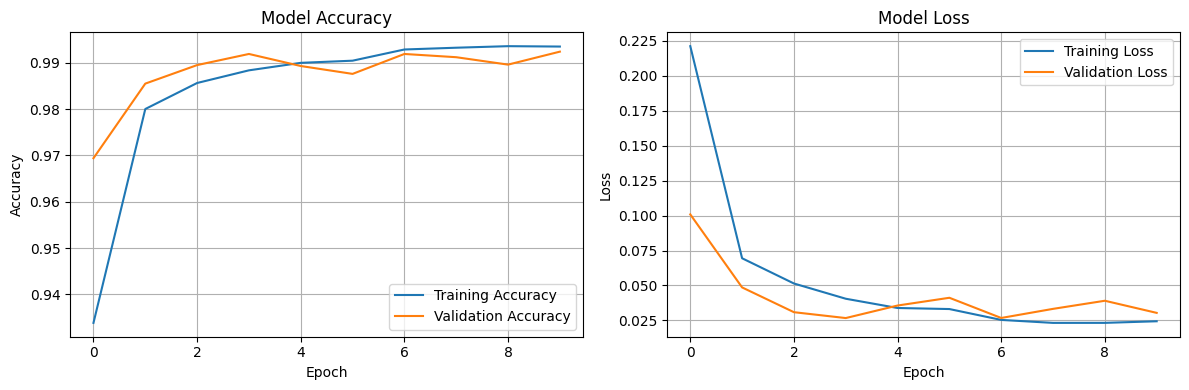

In [20]:
print("\n=== STEP 6: Visualizing Results ===")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# STEP 7: MAKING PREDICTIONS


=== STEP 7: Making Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


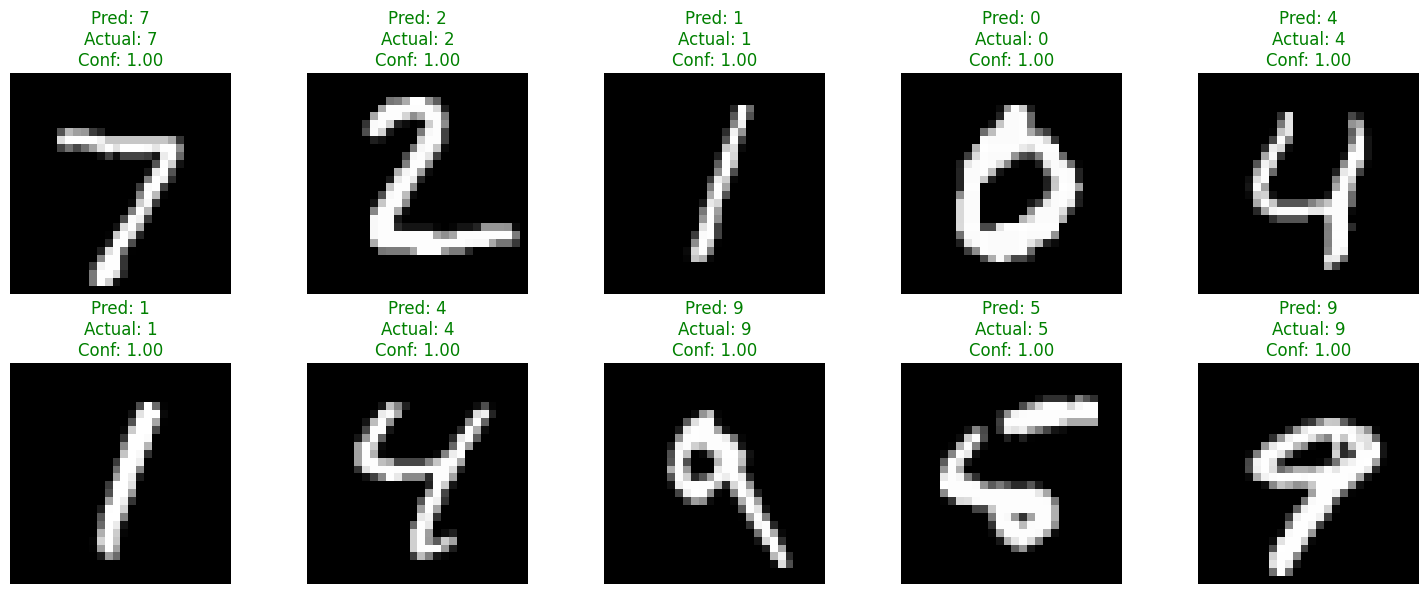

CNN implementation completed successfully!


In [21]:
print("\n=== STEP 7: Making Predictions ===")

# Make predictions on test set
predictions = model.predict(x_test[:10])  # Predict first 10 test images

# Display some predictions
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Display image
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    
    # Get predicted and actual labels
    predicted_label = np.argmax(predictions[i])
    actual_label = np.argmax(y_test[i])
    confidence = np.max(predictions[i])
    
    # Set title with prediction info
    color = 'green' if predicted_label == actual_label else 'red'
    plt.title(f'Pred: {predicted_label}\nActual: {actual_label}\nConf: {confidence:.2f}', 
              color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("CNN implementation completed successfully!")